In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import PIL
import time
import os
from helper import get_car_paths, get_cars_df
from efficientnet_pytorch import EfficientNet
import random
from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch import nn
import torch.optim as optim

from fastai import *
from fastai.vision import *

In [ ]:
def seed_all(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

seed_all(seed=42)

# Download and Untar Data

In [8]:
train_path, test_path = get_car_paths()
train_df = get_cars_df('cars_train_annos.mat')
test_df = get_cars_df('cars_test_annos_withlabels.mat')

WindowsPath('Data/devkit/cars_test_annos_withlabels.mat')

In [ ]:
tfms = get_transforms()
sz = (300, 300)    #Squish Resize if a tuple is defined
bs = 32
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs)
img_data_test = ImageDataBunch.from_df(test_path, test_df,
                                  ds_tfms=None, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs)

# Resnet50

In [ ]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

In [17]:
learn = cnn_learner(img_data, models.resnet50, metrics=[accuracy], loss_func=nn.CrossEntropyLoss(), path='.', callback_fns=ShowGraph)
learn = learn.to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


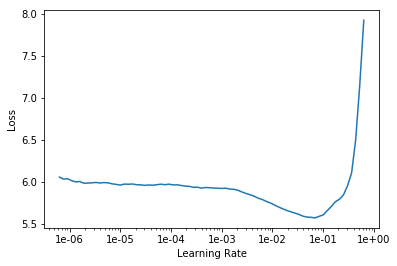

In [18]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr = 3e-3
learn.fit_one_cycle(20, slice(lr/100, lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.563201,0.811671,0.769656,01:31
1,0.543913,0.802018,0.786855,01:31
2,0.564870,0.824799,0.775798,01:31
3,0.556720,0.896798,0.749386,01:31
4,0.581225,0.917678,0.740172,01:30
5,0.532260,0.897425,0.748771,01:31
6,0.462993,0.817315,0.761671,01:30
7,0.432627,0.859559,0.753685,01:31
8,0.370206,0.762988,0.774570,01:30
9,0.342435,0.702082,0.800369,01:31


In [24]:
learn.save('all_trained_1')

In [25]:
learn.load('all_trained_1')

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Hyundai Sonata Hybrid Sedan 2012,Dodge Journey SUV 2012,Dodge Charger Sedan 2012
Path: Data\cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Hyundai Sonata Sedan 2012,Bentley Continental Supersports Conv. Convertible 2012,Audi S6 Sedan 2011,Hyundai Elantra Sedan 2007,Dodge Dakota Club Cab 2007
Path: Data\cars_train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False

In [26]:
lr = 1e-3
learn.fit_one_cycle(20, slice(lr/100, lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.106819,0.518964,0.858108,01:31
1,0.104491,0.519400,0.858108,01:31
2,0.100877,0.516073,0.858722,01:30
3,0.099411,0.548215,0.856880,01:30
4,0.114996,0.573245,0.843366,01:31
5,0.113226,0.553719,0.854423,01:30
6,0.122038,0.562336,0.846437,01:30
7,0.101852,0.548861,0.858108,01:32
8,0.094464,0.558991,0.843980,01:31
9,0.092177,0.542611,0.854423,01:30


In [27]:
learn.save('all_trained_2')

# Resnet101

In [17]:
learn = cnn_learner(img_data, models.resnet101, metrics=accuracy, loss_func=nn.CrossEntropyLoss())

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\zw91/.cache\torch\checkpoints\resnet101-5d3b4d8f.pth
100%|██████████████████████████████████████████████████████████████| 178728960/178728960 [00:06<00:00, 28080962.56it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


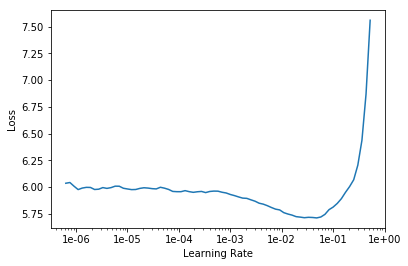

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.583665,3.626280,0.210074,01:45
1,3.286449,2.803197,0.305897,01:46
2,2.841510,2.967973,0.283784,01:45
3,2.327878,2.307493,0.412162,01:44
4,1.920767,1.605085,0.568796,01:45
5,1.562223,1.242372,0.646806,01:46
6,1.154699,1.019961,0.697789,01:47
7,0.912215,0.787502,0.784398,01:45
8,0.655479,0.729222,0.804054,01:45
9,0.554115,0.717690,0.800369,01:45


In [20]:
learn.save("res101_fithead")

In [ ]:
learn.load("res101_fithead")

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(20, slice(5e-5, 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.742536,0.852007,0.763514,02:10
1,1.102805,1.254504,0.651720,02:08
2,1.648124,1.752802,0.546069,02:09
3,1.762555,1.974605,0.481572,02:08
4,1.731679,1.704750,0.557740,02:08
5,1.690728,1.571112,0.561425,02:08
6,1.428213,1.343019,0.632064,02:07
7,1.176003,1.089813,0.699631,02:08
8,1.032962,1.040856,0.710074,02:08
9,0.898748,0.978767,0.724816,02:08


In [23]:
learn.save("res101_finetuned_1")

In [26]:
learn.fit_one_cycle(20, slice(1e-5, 1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.144679,0.438620,0.877150,02:09
1,0.129332,0.434507,0.880221,02:08
2,0.116293,0.435842,0.875921,02:08
3,0.115019,0.444195,0.878993,02:06
4,0.108583,0.438294,0.879607,02:07
5,0.112589,0.450033,0.874693,02:08
6,0.115162,0.443240,0.878378,02:08
7,0.104475,0.432894,0.880835,02:07
8,0.109463,0.437267,0.874693,02:08
9,0.102126,0.442187,0.875921,02:07


In [27]:
learn.save("res101_finetuned_2")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


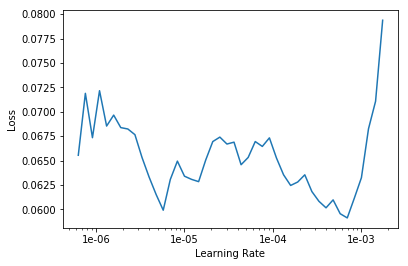

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.078395,0.428655,0.880221,02:08
1,0.091252,0.428303,0.885749,02:07
2,0.083178,0.425754,0.886364,02:07
3,0.087686,0.424581,0.884521,02:08
4,0.081180,0.429311,0.884521,02:09
5,0.079274,0.426934,0.885749,02:08
6,0.080421,0.430178,0.888206,02:07
7,0.087782,0.432723,0.882678,02:08
8,0.069903,0.425833,0.887592,02:08
9,0.071131,0.427522,0.889435,02:08


In [30]:
learn.save("res101_finetuned_3")

# Resnet34

In [18]:
learn = cnn_learner(img_data, models.resnet34, metrics=accuracy, loss_func=nn.CrossEntropyLoss(), pretrained=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


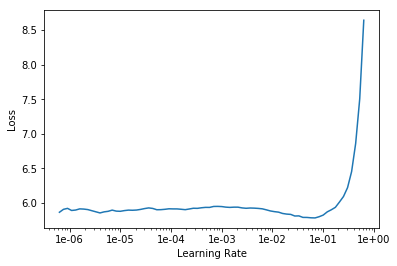

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.809181,3.890660,0.151720,01:51
1,3.713586,3.235898,0.245086,01:50
2,3.305220,3.363468,0.228501,01:51
3,2.895026,2.439208,0.397420,01:50
4,2.549850,2.231602,0.425061,01:50
5,2.074748,1.792187,0.533784,01:51
6,1.671270,1.369933,0.622850,01:50
7,1.373115,1.178388,0.670147,01:48
8,1.120458,1.088342,0.700860,01:47
9,1.009473,1.080543,0.694717,01:47


In [21]:
learn.save("res34_fithead")

In [22]:
learn.unfreeze()

In [23]:
lr = 3e-3
wd = 1e-2
learn.fit_one_cycle(10, slice(lr/100, lr/10, lr), wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.993684,1.065457,0.708231,01:49
1,1.079168,1.299494,0.639435,01:48
2,1.114627,1.158724,0.680590,01:48
3,0.974121,0.942101,0.733415,01:47
4,0.811585,0.905138,0.741400,01:48
5,0.713942,0.844066,0.771499,01:48
6,0.566524,0.729500,0.802211,01:49
7,0.477597,0.689194,0.810811,01:52
8,0.442690,0.675311,0.813268,01:51
9,0.404514,0.670167,0.808968,01:50


In [25]:
lr = 3e-4
wd = 1e-4
learn.fit_one_cycle(10, slice(lr/100, lr/10, lr), wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.238730,0.631815,0.828010,01:52
1,0.254036,0.628500,0.826781,01:52
2,0.255002,0.633807,0.828010,01:52
3,0.255341,0.625219,0.828010,01:52
4,0.268000,0.622689,0.829853,01:53
5,0.236918,0.621751,0.834152,01:51
6,0.235801,0.615150,0.837838,01:53
7,0.206756,0.620532,0.830467,01:52
8,0.209439,0.616177,0.831695,01:52
9,0.222366,0.615570,0.834767,01:51


# DenseNet

In [17]:
learn = cnn_learner(img_data, models.densenet121, metrics=accuracy, loss_func=nn.CrossEntropyLoss(), pretrained=True)

In [18]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 8.00 GiB total capacity; 5.88 GiB already allocated; 27.85 MiB free; 120.17 MiB cached)

In [ ]:
learn.fit_one_cycle(10, 1e-2)